In [1]:
# Load Data
%%bash
pip install pyspark
# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./players_20.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=adb67c7abc4daafae33eee692d46e4b859c6e2045ef302184ed4136f072d2e40
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-30 03:20:37--  https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945067 (8.5M) [text/plain]
Saving to: ‘players_20.csv’

     0K .......... .......... .......... .......... ..........  0% 3.90M 2s
    50K .......... .......... .......... .......... ..........  1% 10.3M 1s
   100K .......... .......... .......... .......... ..........  1% 4.68M 2s
   150K .......... .......... .......... .......... ..........  2% 15.2M 1s
   200K .......... .......... .......... .......... ..........  2% 6.68M 1s
   250K .......... .......... .......... .......... ..........  3% 24.2M 1s
   300K .......... .......... .......... .......... ..........  4% 35.7M 1s
   350K .......... .......... .

In [2]:
# The first code cell of your notebook shall include all needed imports to run your project code.  Note that
# there can be markdown cells above this cell.
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, split, isnan, when, count, isnull, udf, asc
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel, StringIndexer, OneHotEncoder, StandardScaler, PCA, VectorAssembler
from matplotlib import pyplot as plt
from pyspark.sql.types import FloatType, IntegerType, DoubleType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## loading data

In [4]:
original_data = spark.read.csv("players_20.csv", inferSchema=True, header=True)

## Data exploration

### statistic summary

In [5]:
statistic_col = ['age', 'height_cm', 'weight_kg', 'overall', 'value_eur', 'wage_eur', 'release_clause_eur']
statistic_data = original_data.select(statistic_col).toPandas()
statistic_data.describe()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,release_clause_eur
count,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000,1.698000e+04
mean,25.283291,181.362184,75.276343,66.244994,2.484038e+06,9456.942773,4.740717e+06
std,4.656964,6.756961,7.047744,6.949953,5.585481e+06,21351.714095,1.103002e+07
min,16.000000,156.000000,50.000000,48.000000,0.000000e+00,0.000000,1.300000e+04
25%,22.000000,177.000000,70.000000,62.000000,3.250000e+05,1000.000000,5.630000e+05
50%,25.000000,181.000000,75.000000,66.000000,7.000000e+05,3000.000000,1.200000e+06
75%,29.000000,186.000000,80.000000,71.000000,2.100000e+06,8000.000000,3.700000e+06
max,42.000000,205.000000,110.000000,94.000000,1.055000e+08,565000.000000,1.958000e+08


### visualization

Text(0.5, 1.0, 'Correlation heatmap')

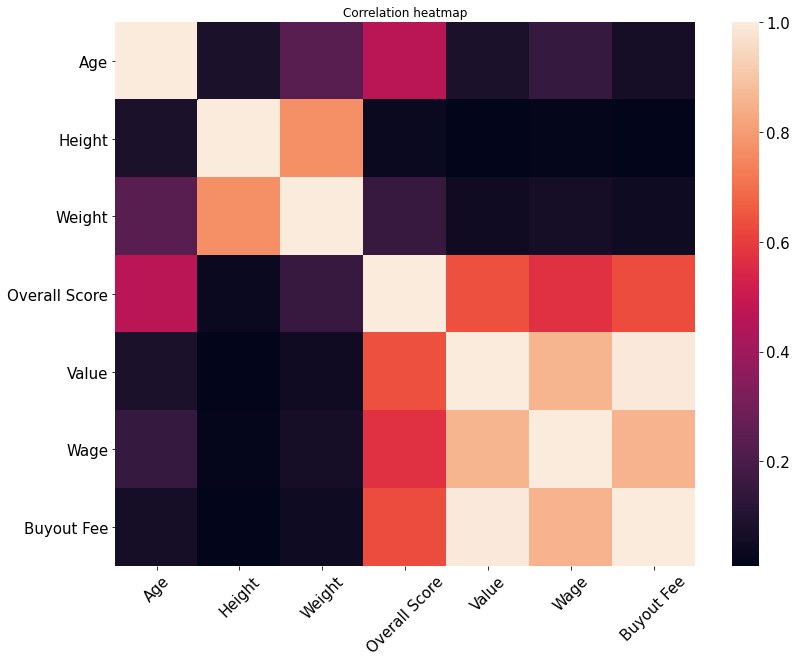

In [6]:
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.figure(figsize=(13,10))
corr = statistic_data.corr()
ax = sns.heatmap(corr, 
        xticklabels=['Age', 'Height', 'Weight', 'Overall Score', 'Value', 'Wage', 'Buyout Fee'],
        yticklabels=['Age', 'Height', 'Weight', 'Overall Score', 'Value', 'Wage', 'Buyout Fee'])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0
)
plt.title('Correlation heatmap')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


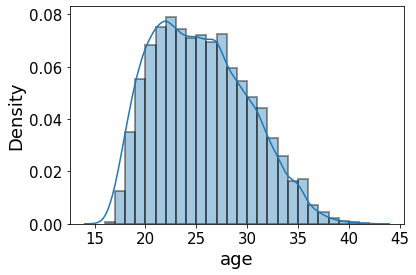

In [7]:
plot_data = original_data.select(['age', 'nationality', 'player_positions', 'preferred_foot', 'club', 'overall']).toPandas()
plt.rc('font', size=18)
sns.distplot(plot_data['age'], bins=26, hist_kws=dict(edgecolor="k", linewidth=2))

Text(0.5, 1.0, 'Each Nationality Player Count')

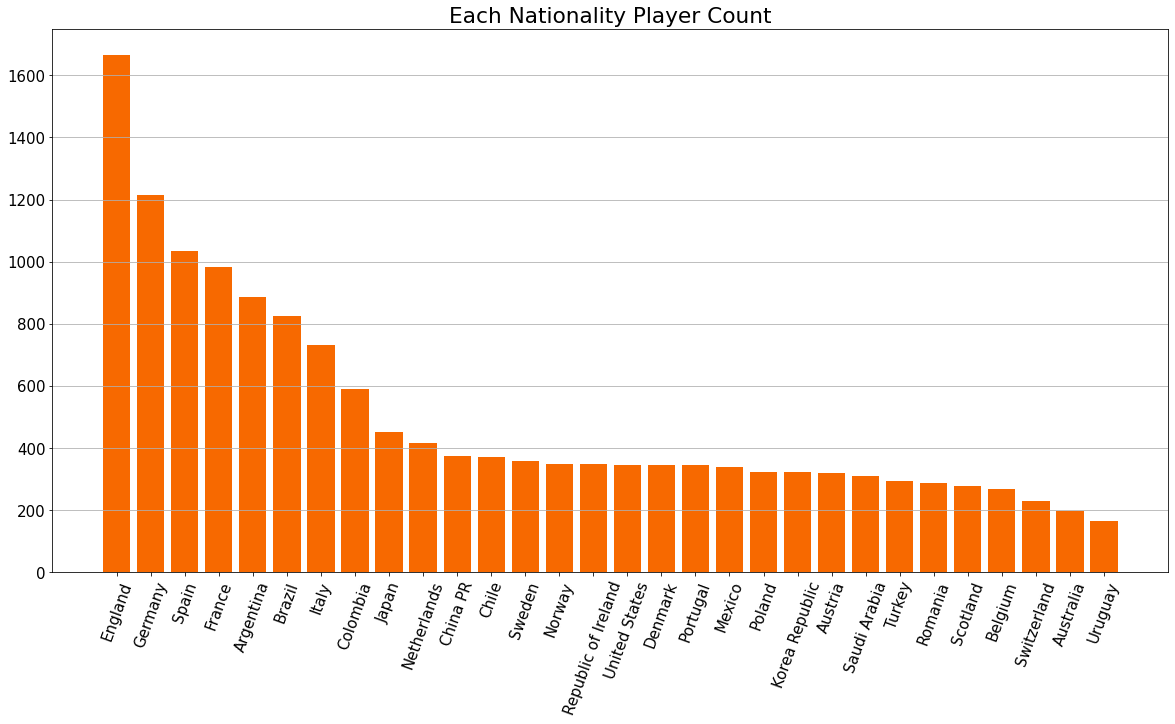

In [8]:
plt.rc('font', size=18)
plt.figure(figsize=(20,10))
plt.xticks(rotation=70)
plt.grid(axis='y')
plt.bar(plot_data.nationality.value_counts()[:30].index, plot_data.nationality.value_counts()[:30], color = '#F76900', edgecolor = 'none')
plt.title('Each Nationality Player Count')

Text(0.5, 1.0, 'Position')

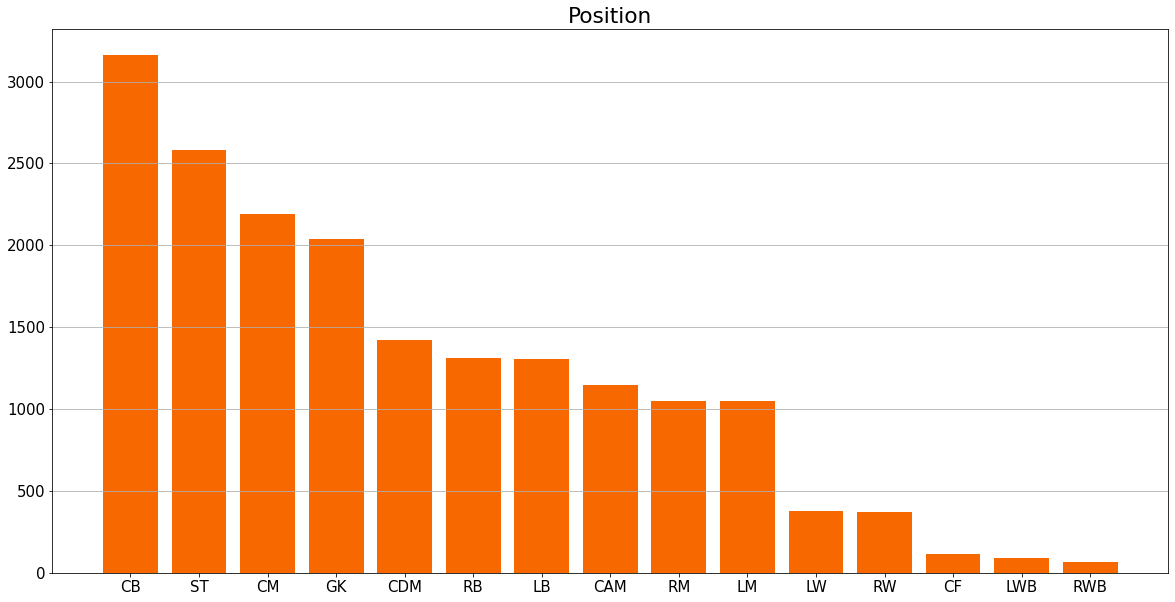

In [9]:
position = plot_data.player_positions.str.split(',', expand=True)
plt.rc('font', size=18)
plt.figure(figsize=(20,10))
plt.grid(axis='y')
plt.bar(position.iloc[:,0].value_counts()[:30].index, position.iloc[:,0].value_counts()[:30], color = '#F76900', edgecolor = 'none')
plt.title('Position')


Text(0.5, 1.0, 'Distribution of different preferred foot')

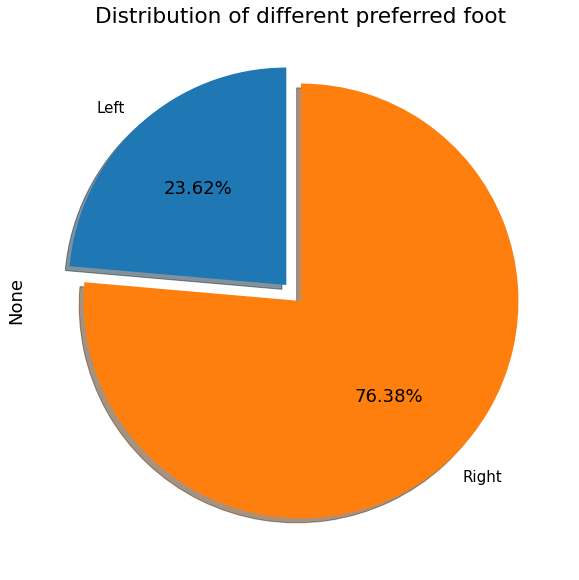

In [10]:
plt.figure(figsize=(20,10))
plot_data.groupby('preferred_foot').size().plot(kind='pie', autopct='%.2f%%', explode = (0.1, 0), shadow=True, startangle=90)
plt.title('Distribution of different preferred foot')

In [11]:
sort_data = plot_data[plot_data['overall'] > 82]
sort_data = sort_data['club'].value_counts()[sort_data['club'].value_counts()>1]

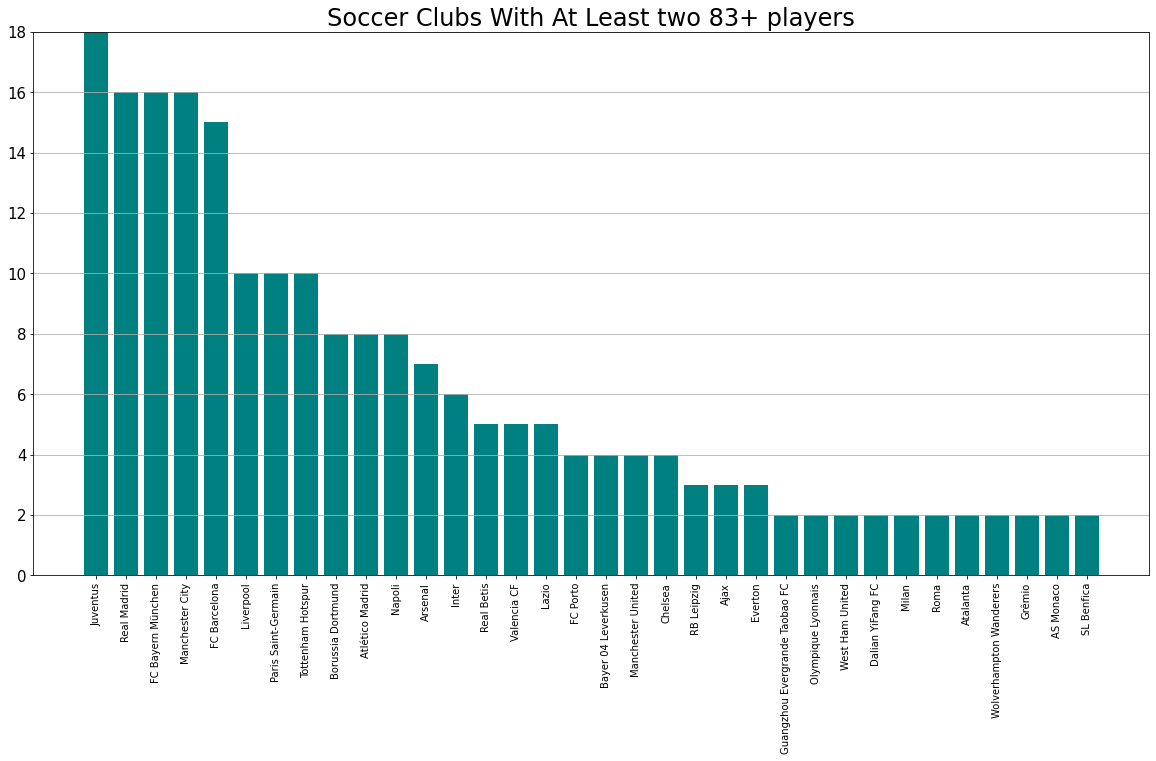

In [12]:
plt.rc('font', size=20)
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(20,10))
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.bar(sort_data.index, sort_data, color = 'teal', edgecolor = 'none')
plt.ylim((0, 18) )
plt.title('Soccer Clubs With At Least two 83+ players')
plt.show()

## data preprocessing

In [13]:
# drop useless columns
drop1_columns = ['sofifa_id', 'player_url', 'long_name', 'player_tags', 'player_traits', 'real_face', 'nation_jersey_number', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until']
fixed1_Data = original_data.drop(*drop1_columns)

In [14]:
# drop position ability(duplicated and will affect the final result)
drop2_columns = fixed1_Data.columns[-26:]
fixed2_Data = fixed1_Data.drop(*drop2_columns)

In [15]:
# drop duplicated columns
drop3_columns = ['wage_eur', 'team_position', 'release_clause_eur', 'nation_position', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
fixed3_Data = fixed2_Data.drop(*drop3_columns)

In [16]:
# split player_positions and choose the first position as primary position
split_col = split(fixed3_Data['player_positions'], ',')
position_data = fixed3_Data.withColumn('Position', split_col.getItem(0))
position_data = position_data.drop('player_positions')

In [17]:
# split work_Rate 
split_col = split(position_data['work_rate'], '/')
position_data = position_data.withColumn('Attack_workrate', split_col.getItem(0))
position_data = position_data.withColumn('Defend_workrate', split_col.getItem(1))
position_data = position_data.drop('work_rate')

In [18]:
# narrow down positions: defender
defender = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']
defender_data = position_data.filter(col('Position').isin(defender)).withColumn('Positon_General', lit('Defender'))
defender_data.count()

5938

In [19]:
# midfileder
midfileder = ['LCM', 'LM', 'RDM', 'CAM', 'RAM', 'RCM', 'CM', 'CDM', 'RM', 'LAM', 'LDM']
midfileder_data = position_data.filter(col('Position').isin(midfileder)).withColumn('Positon_General', lit('Midfileder'))
midfileder_data.count()

6862

In [20]:
# attacker
attacker = ['ST', 'CF', 'LW', 'RW']
attacker_data = position_data.filter(col('Position').isin(attacker)).withColumn('Positon_General', lit('Attacker'))
attacker_data.count()

3442

In [21]:
# goal keeper
gk_data = position_data.filter(col('Position').isin(['GK'])).withColumn('Positon_General', lit('GK'))
gk_data.count()

2036

In [22]:
general_data = defender_data.union(midfileder_data).union(attacker_data).union(gk_data)

In [23]:
# missing values: 
general_data.select([count(when(isnull(c), c)).alias(c) for c in general_data.columns]).show()

+----------+---+---+---------+---------+-----------+----+-------+---------+---------+--------------+------------------------+---------+-----------+---------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+-----------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------+---------------+---------------+---------------+
|short_name|age|dob|height_cm|weight_kg|nationality|club|overall|potential|value_eur|preferred_foot|international_reputat

In [24]:
# duplicated values: general data
if general_data.count() == general_data.drop_duplicates().count():
  print('No duplicated records.')

No duplicated records.


In [25]:
# feature engineering for clustering
# numerlize categorical data
# Rate: low, medium, high: 0, 1, 2
# foot: left, right: 1, 0
cluster_data_prepipe = Pipeline(stages=[
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Attack_workrate', outputCol='Attack_workrate_num'),
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Defend_workrate', outputCol='Defend_workrate_num'),
                                StringIndexer(inputCols=["preferred_foot", "body_type", "Positon_General"], outputCols=["preferred_foot_num", "body_type_num", "Positon_General_num"]),
                                OneHotEncoder(inputCols=['preferred_foot_num', 'body_type_num'], outputCols=['foot', 'body'])
])

In [26]:
cluster_data_xformed = cluster_data_prepipe.fit(general_data).transform(general_data)

In [27]:
# feature engineering for others
data_prepipe = Pipeline(stages=[
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Attack_workrate', outputCol='Attack_workrate_num'),
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Defend_workrate', outputCol='Defend_workrate_num'),
                                StringIndexer(inputCols=["preferred_foot", "Positon_General"], outputCols=["preferred_foot_", "Positon_label"])
])

In [28]:
general_data_xformed = data_prepipe.fit(general_data).transform(general_data)
general_data_xformed = general_data_xformed.drop('preferred_foot').\
                      withColumnRenamed('preferred_foot_','preferred_foot')

In [29]:
#select numeric columns as features
feature_col = []
for cols,types in general_data_xformed.dtypes:
  if types in ['int','double']:
    feature_col.append(cols)
#remove target
feature_col.remove('value_eur')
feature_col.remove('Positon_label')
feature_col.remove('overall')
feature_col.remove('potential')

In [30]:
#train test set split
train_set, test_set = general_data_xformed.randomSplit([0.7,0.3],seed = 0)

## Regression modle

In [31]:
#skip time-consuming process grid search
Grid_search = True

### Linear regression

In [32]:
#define r square evaluator
r_square = RegressionEvaluator(labelCol='value_eur', metricName='r2')
#define mse evaluator
mse = RegressionEvaluator(labelCol='value_eur', metricName='mse')

#### Basic model training and evaluating

In [33]:
#make linear regression pipeline and train the model
va = VectorAssembler(inputCols = feature_col,
                     outputCol = 'features')
lr = LinearRegression(featuresCol = 'features',
                      labelCol='value_eur',
                      predictionCol = 'prediction').\
                      setMaxIter(10)
LR_pipe = Pipeline(stages = [va,lr])
LR_pipe_fitted = LR_pipe.fit(train_set)
Predict_LR = LR_pipe_fitted.transform(test_set)

In [34]:
#mse evaluator
lr_mse = mse.evaluate(Predict_LR)
#r^2 evaluator
lr_r2 = r_square.evaluate(Predict_LR)
print('basic model evaluation:\n ''mse:',lr_mse,'\n r2:',lr_r2)

basic model evaluation:
 mse: 12653485714529.701 
 r2: 0.5461485424578842


#### Elastic net regurlarization

In [35]:
#add elastic net regularization to linear regression
elastic_net_alpha = np.arange(0,1,.3)
elastic_net_lambda = np.arange(.00,.90,.15)
#do grid search using each parameters
grid = ParamGridBuilder()\
          .addGrid(lr.regParam, elastic_net_lambda ) \
          .addGrid(lr.elasticNetParam, elastic_net_alpha) \
          .build()
cv = CrossValidator(estimator=LR_pipe,
                                estimatorParamMaps=grid,
                                evaluator=r_square,
                                numFolds = 3,
                                seed = 0)
lr_cv = cv.fit(train_set)

In [36]:
#train the model with best hyperparameter
MaxIter = lr_cv.bestModel.stages[-1].getMaxIter()
ElasticNetParam = lr_cv.bestModel.stages[-1].getElasticNetParam()
RegParam = lr_cv.bestModel.stages[-1].getRegParam()
# RegParam = 0.75
# ElasticNetParam = 0
va = VectorAssembler(inputCols = feature_col,
                     outputCol = 'features')
lr = LinearRegression(featuresCol = 'features',
                      labelCol='value_eur',
                      predictionCol = 'prediction',
                      maxIter = MaxIter,
                      regParam = RegParam,
                      elasticNetParam = ElasticNetParam)
LR_pipe_best = Pipeline(stages = [va,lr])
LR_pipe_fitted_best = LR_pipe_best.fit(train_set)
Predict_best_LR = LR_pipe_fitted_best.transform(test_set)

In [37]:
#mse of best model
test_mse_linear = mse.evaluate(Predict_best_LR)
#r2 of the best model
test_r2_linear = r_square.evaluate(Predict_best_LR)
print('Model after tuning evaluation:\n ''mse:',test_mse_linear,'\n r2:',test_r2_linear)

Model after tuning evaluation:
 mse: 12653485525336.783 
 r2: 0.5461485492437996


In [38]:
coef = LR_pipe_fitted_best.stages[-1].coefficients
ipt = LR_pipe_fitted_best.stages[-1].intercept

#### Model performance result

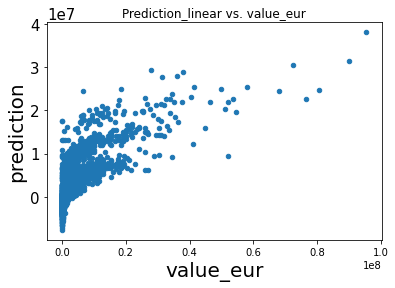

In [39]:
#visualiza prediction and value_eur to
Predict_best_LR.select('prediction', 'value_eur').toPandas().plot(x = 'value_eur', y = 'prediction', kind = 'scatter')
plt.rc('font', size=10)
plt.title('Prediction_linear vs. value_eur')
plt.show()
#The model is strongly linear related

### Random Forest Regression

In [40]:
#make and train randomforest regressor pipeline
rfr = RandomForestRegressor(featuresCol='features', labelCol = 'value_eur',
                            seed = 0)
rfr_pipe = Pipeline(stages=[va,rfr])
rfr_fitted = rfr_pipe.fit(train_set)

In [41]:
#tranform
rfr_pred = rfr_fitted.transform(test_set)

In [42]:
#mse of the model
rf_mse = mse.evaluate(rfr_pred)
#r2 of the best model
rf_r2 = r_square.evaluate(rfr_pred)
print('Basic model:\n ''mse:',rf_mse,'\n r2:',rf_r2)

Basic model:
 mse: 5379498261344.142 
 r2: 0.8070497583165716


#### Hyperparameter tuning

In [43]:
#do grid search to find best model
rf = RandomForestRegressor().\
      setFeaturesCol('features').\
      setLabelCol('value_eur')
rf_pipe = Pipeline(stages=[va, rf])
#build parameters grid and cross validation model
grid = ParamGridBuilder().\
          addGrid(rf.numTrees,[10,50,100]).\
          addGrid(rf.maxDepth,[10,20]).\
          addGrid(rf.minInstancesPerNode,[10,50]).\
          addGrid(rf.subsamplingRate,[0.1,0.2]).\
          build()
rf_cv = CrossValidator(estimator=rf_pipe,
                      estimatorParamMaps = grid,
                      evaluator = mse,
                      numFolds=2,
                      seed = 0)
rf_cv_fitted = rf_cv.fit(general_data_xformed)

In [44]:
#extract hyperparameter of best model
NumTrees = rf_cv_fitted.bestModel.stages[1].getNumTrees
MinInstancesPerNode = rf_cv_fitted.bestModel.stages[1].getMinInstancesPerNode()
MaxDepth = rf_cv_fitted.bestModel.stages[1].getMaxDepth()
SubsamplingRate = rf_cv_fitted.bestModel.stages[1].getSubsamplingRate()
# NumTrees = 100
# MinInstancesPerNode = 10
# MaxDepth = 20
# SubsamplingRate = 0.2
#construct rf model with the best hyperparameter
rf = RandomForestRegressor(numTrees=NumTrees,
                           maxDepth = MaxDepth,
                           subsamplingRate = SubsamplingRate,
                           minInstancesPerNode = MinInstancesPerNode,
                           seed = 0).\
     setFeaturesCol('features').\
     setLabelCol('value_eur')
rf_bpipe = Pipeline(stages=[va, rf])
best_pipe = rf_bpipe.fit(train_set)

In [45]:
#fit model with test data set
rfr_best_df = best_pipe.transform(test_set)

In [46]:
#rmse of best randomforest model
test_mse_rf = mse.evaluate(rfr_best_df)
#r_square of the best randomforest
test_r2_rf = r_square.evaluate(rfr_best_df)
print('Model after tuning:\n ''mse:',test_mse_rf,'\n r2:',test_r2_rf)

Model after tuning:
 mse: 6650193674593.624 
 r2: 0.7614728336330323


#### Feature importance visualization

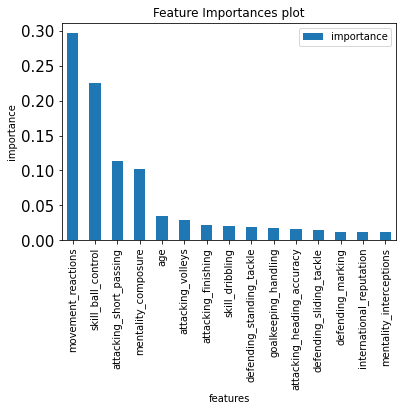

In [47]:
#out put feature importances
featureImportances = pd.DataFrame(list(zip(feature_col, best_pipe.stages[-1].featureImportances)),
            columns = ['column', 'importance']).sort_values('importance', ascending = False)
featureImportances[featureImportances['importance'] > .01].plot(y='importance', x='column', kind = "bar" )
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature Importances plot')
plt.show()

### Gradient Boosting Machine Regression

In [48]:
#do a grid search
gbt = GBTRegressor(maxIter = 10, maxDepth = 4, seed = 0).\
      setFeaturesCol('features').\
      setLabelCol('value_eur')
gbt_pipe = Pipeline(stages=[va, gbt])
#build parameters grid and cross validation model 
#search for the best learning rate of GBM
train_r2 = []
test_r2 = []
stepsize = np.arange(0.1,0.9,0.1)
for step in stepsize:
  grid_gbt = ParamGridBuilder().\
          addGrid(gbt.stepSize,[step]).\
            build()
  gbt_cv = CrossValidator(estimator=gbt_pipe,
                        estimatorParamMaps = grid_gbt,
                        evaluator = mse,
                        numFolds=2,
                        seed = 0)
  gbt_cv_fitted = gbt_cv.fit(general_data_xformed)
  train_r2.append(r_square.evaluate(gbt_cv_fitted.bestModel.transform(train_set)))
  test_r2.append(r_square.evaluate(gbt_cv_fitted.bestModel.transform(test_set)))

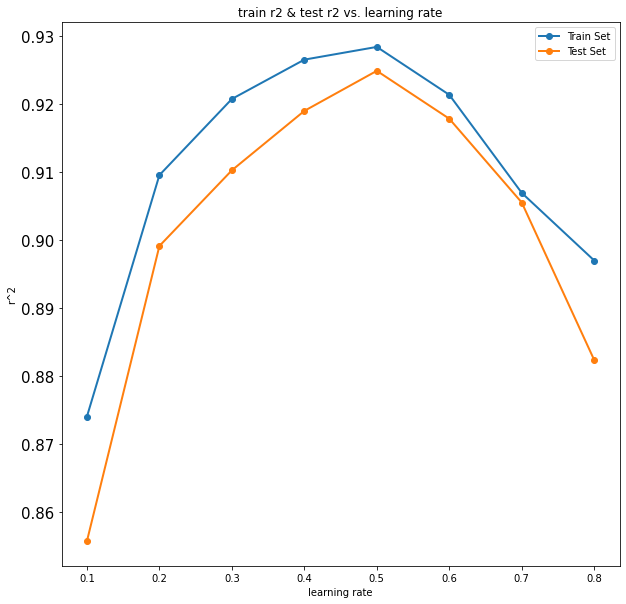

In [49]:
#visualize train r2 & test r2 vs. learning rate
#learning rate - 0.6
plt.figure(figsize=(10,10))
plt.plot(stepsize, train_r2, 'o-', linewidth=2, label="Train Set")
plt.plot(stepsize, test_r2, 'o-', linewidth=2, label="Test Set")
plt.title('train r2 & test r2 vs. learning rate')
plt.xlabel("learning rate")
plt.ylabel("r^2")
plt.legend()
plt.show()

In [50]:
#CV model contains pipe model containing gbtregressor
gbt_best = GBTRegressor(maxDepth=10,
                        stepSize=0.5,
                        maxIter=4,
                        seed = 0).\
                        setFeaturesCol('features').\
                        setLabelCol('value_eur')
gbt_best_pipe = Pipeline(stages=[va, gbt_best])
gbt_best_fitted = gbt_best_pipe.fit(train_set)
gbt_test_df  = gbt_best_fitted.transform(test_set)
test_mse_gbt = round(mse.evaluate(gbt_test_df),2)
test_r2_gbt = round(r_square.evaluate(gbt_test_df),2)
print('Model after tuning:\n ''mse:',test_mse_gbt,'\n r2:',test_r2_gbt)

Model after tuning:
 mse: 7925517095656.42 
 r2: 0.72


### Linear model comparation

In [51]:
#model comparation
compare_df = pd.DataFrame(list(zip(['LR',' RF','GBT'], [test_mse_linear, test_mse_rf, test_mse_gbt],
                                     [test_r2_linear, test_r2_rf, test_r2_gbt])),
            columns = ['model', 'mse','r^2'])
display(compare_df)

,model,mse,r^2
0,LR,1.265349e+13,0.546149
1,RF,6.650194e+12,0.761473
2,GBT,7.925517e+12,0.720000


## Classification modle

In [52]:
#define auto f1 score evaluator
def f1_evaluation(model_pipeline, model_fitted, data):
  return MulticlassClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(), 
                                predictionCol=model_pipeline.getStages()[-1].getPredictionCol()).\
    evaluate(model_fitted.transform(data))
#define auto accuracy evaluator
def accuracy_evaluation(model_pipeline, model_fitted, data):
  return MulticlassClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(),
                                           metricName = 'accuracy', 
                                predictionCol=model_pipeline.getStages()[-1].getPredictionCol()).\
    evaluate(model_fitted.transform(data))
#define f1 multiclass evaluator
f1 = MulticlassClassificationEvaluator(labelCol='Positon_label', predictionCol='prediction')
#define accuracy multiclass evaluator
accuracy = MulticlassClassificationEvaluator(labelCol='Positon_label', predictionCol='prediction',
                                             metricName = 'accuracy')

### Multi-class logistic regression

#### Basic model training and evaluating

In [53]:
#train the model without hyperparametertuning 
lrc = LogisticRegression(maxIter=10).\
      setLabelCol('Positon_label')
lrc_pipe = Pipeline(stages=[va,lrc])
lrc_fitted = lrc_pipe.fit(train_set)
print('Basic model f1:')
lrc_f1 = f1_evaluation(lrc_pipe, lrc_fitted, test_set)
print(lrc_f1)
print('Basic model accuracy:')
lrc_acc = accuracy_evaluation(lrc_pipe, lrc_fitted, test_set)
print(lrc_acc)

Basic model f1:
0.7960171869417222
Basic model accuracy:
0.796078431372549


#### Elastic regularization and Grid search

In [54]:
#add regularization to logistic regression
elastic_net_alpha = np.arange(0,1,.3)
elastic_net_lambda = np.arange(.00,.90,.15)
#do grid search to find the best model
grid = ParamGridBuilder().\
          addGrid(lr.elasticNetParam,elastic_net_alpha).\
          addGrid(lr.regParam,elastic_net_lambda).\
          build()
cv = CrossValidator(estimator=lrc_pipe,
                      estimatorParamMaps = grid,
                      evaluator = f1,
                      numFolds = 3,
                      seed = 0)
lrc_cv = cv.fit(train_set)

In [55]:
#output hyperparameters
lrc_best = lrc_cv.bestModel
lmd = lrc_best.stages[-1].getElasticNetParam()
a = lrc_best.stages[-1].getRegParam()
print('lambda:',lmd,'\nalpha:',a)
#output f1 score
print('f1 after tuning:')
lrc_f1 = f1_evaluation(lrc_pipe, lrc_best, test_set)
print(lrc_f1)
print('Accuracy after tuning:')
lrc_accuracy = accuracy_evaluation(lrc_pipe, lrc_best, test_set)
print(lrc_accuracy)
#model performs the best when there is no regularization

lambda: 0.0 
alpha: 0.0
f1 after tuning:
0.7960171869417222
Accuracy after tuning:
0.796078431372549


#### Model performance evaluation

In [56]:
#extract recall and precision by label from logisticregression summary
LRC_summary = lrc_best.stages[-1].summary
LRC_summary.accuracy
LRC_summary.recallByLabel
LRC_summary.precisionByLabel

[0.7432404540763674, 0.8351539225422046, 0.8057285180572852, 1.0]

In [57]:
position_name = ['Midfileder','Defender','Attacker','GK']
#output recall by label
pd.DataFrame(list(zip(position_name, LRC_summary.recallByLabel)),
            columns = ['target_label', 'recall'])

,target_label,recall
0,Midfileder,0.763085
1,Defender,0.813543
2,Attacker,0.799423
3,GK,1.000000


In [58]:
#output recall, precision, data table
#output precision by label
pd.DataFrame(list(zip(position_name, LRC_summary.precisionByLabel)),
            columns = ['target_label', 'precision'])

,target_label,precision
0,Midfileder,0.743240
1,Defender,0.835154
2,Attacker,0.805729
3,GK,1.000000


Seen that goal keeper player is different to other 3 kinds of players

### Random Forest classificition

#### Basic Model training and evaluation

In [59]:
#construct pipeline model
rfc = RandomForestClassifier(seed = 0).\
      setLabelCol('Positon_label')
rfc_pipe = Pipeline(stages=[va,rfc])
rfc_fitted = rfc_pipe.fit(train_set)

In [60]:
#calculate accuracy
print('f1:')
rfc_acc = f1_evaluation(rfc_pipe, rfc_fitted, test_set)
print(rfc_acc)
print('Accuracy:')
rfc_acc = accuracy_evaluation(lrc_pipe, lrc_best, test_set)
print(rfc_acc)

f1:
0.838273254114523
Accuracy:
0.796078431372549


#### Hyperparameter tuning

In [61]:
#do a grid search
grid = ParamGridBuilder().\
          addGrid(rfc.numTrees,[10,50,100]).\
          addGrid(rfc.maxDepth,[10,20]).\
          addGrid(rfc.impurity,['gini','entropy']).\
          build()
rfc_cv = CrossValidator(estimator=rfc_pipe,
                        estimatorParamMaps = grid,
                      evaluator = f1,
                      numFolds=2,
                      seed = 0)
rfc_cv_fitted = rfc_cv.fit(general_data_xformed)

In [62]:
#extract hyperparameter of best model
NumTrees = rfc_cv_fitted.bestModel.stages[1].getNumTrees
MaxDepth = rfc_cv_fitted.bestModel.stages[1].getMaxDepth()
Impurity = rfc_cv_fitted.bestModel.stages[1].getImpurity()
rfc_best = RandomForestClassifier(numTrees=NumTrees,
                           maxDepth = MaxDepth,
                           subsamplingRate = SubsamplingRate,
                           minInstancesPerNode = MinInstancesPerNode,
                           impurity = Impurity,
                           seed = 0).\
                            setFeaturesCol('features').\
                           setLabelCol('Positon_label')
rfc_bpipe = Pipeline(stages=[va, rfc_best])
rfc_best_pipe = rfc_bpipe.fit(train_set)

In [63]:
rfc_best_pipe.transform(test_set)

DataFrame[short_name: string, age: int, dob: string, height_cm: int, weight_kg: int, nationality: string, club: string, overall: int, potential: int, value_eur: int, international_reputation: int, weak_foot: int, skill_moves: int, body_type: string, attacking_crossing: int, attacking_finishing: int, attacking_heading_accuracy: int, attacking_short_passing: int, attacking_volleys: int, skill_dribbling: int, skill_curve: int, skill_fk_accuracy: int, skill_long_passing: int, skill_ball_control: int, movement_acceleration: int, movement_sprint_speed: int, movement_agility: int, movement_reactions: int, movement_balance: int, power_shot_power: int, power_jumping: int, power_stamina: int, power_strength: int, power_long_shots: int, mentality_aggression: int, mentality_interceptions: int, mentality_positioning: int, mentality_vision: int, mentality_penalties: int, mentality_composure: int, defending_marking: int, defending_standing_tackle: int, defending_sliding_tackle: int, goalkeeping_divin

In [64]:
#calculate f1 score
print('f1 after tuning:')
rfc_best_f1 = f1_evaluation(rfc_pipe, rfc_best_pipe, test_set)
print(rfc_best_f1)
#calculate accuracy
print('Accuracy after tuning:')
rfc_best_acc = accuracy_evaluation(rfc_pipe, rfc_best_pipe, test_set)
print(rfc_best_acc)

f1 after tuning:
0.8844617010192888
Accuracy after tuning:
0.8848484848484849


#### Feature Importance visualization

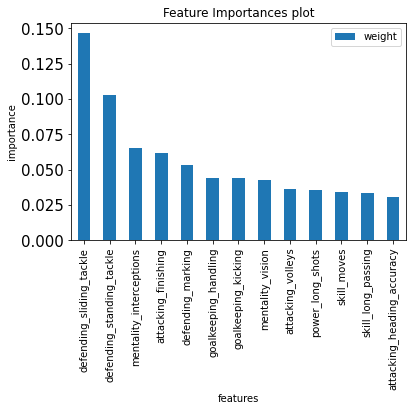

In [65]:
#output feature imporatances
featureImportances = pd.DataFrame(list(zip(feature_col, rfc_best_pipe.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight', ascending = False)
featureImportances[featureImportances['weight'] > .03].plot(y='weight', x='column', kind = "bar" )
plt.title('Feature Importances plot')
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

In [66]:
# clustering and recommender system

In [67]:
# find out all columns we need for pca, clustering and recommender system
remove_columns = ['short_name', 'dob', 'nationality', 'club', 'preferred_foot', 'body_type', 'Position', 'Attack_workrate', 'Defend_workrate', 'Positon_General']
va_columns = list(set(cluster_data_xformed.columns) - set(remove_columns))

In [68]:
# vector assemble and standardization
recommender_va = VectorAssembler(inputCols=va_columns, outputCol='feature')

In [69]:
standardization = StandardScaler(withMean=True, withStd=True, inputCol='feature', outputCol='std_feature')

## Clustering model

### Recommender system

In [70]:
# recommender system
recommender_pca = PCA(k=2, inputCol='std_feature', outputCol='scores')
recommender_pipe = Pipeline(stages=[recommender_va, standardization, recommender_pca]).fit(cluster_data_xformed)
recommender_data = recommender_pipe.transform(cluster_data_xformed)

In [71]:
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

l2_dist_udf = udf(l2_dist, FloatType())

In [72]:
def recommender_system(name, num_players):
  try:
    cha = list([name])
    num = int(num_players)
  except:
    return 'Check your inputs!'

  condition = (col('short_name') == cha[0])

  length_check = (len(cha) == 1)
  exist_check = recommender_data.where(condition).count() !=0

  if length_check & exist_check:
    
    result_df = recommender_data.where(condition).select(col("scores").alias('target_scores')).join(recommender_data).withColumn('dist', l2_dist_udf('scores', 'target_scores')).\
    select("short_name", "overall", "Position", 'value_eur',"dist").\
    orderBy(asc("dist")).\
    limit(num+1)

    result = result_df.select('short_name').rdd.map(lambda x: x['short_name']).collect()
    result.remove(cha[0])
  else:
    return 'Check your inputs!'
  
  return result_df.show()

#### Result

In [73]:
recommender_system('L. Messi',5)

+-----------------+-------+--------+---------+---------+
|       short_name|overall|Position|value_eur|     dist|
+-----------------+-------+--------+---------+---------+
|         L. Messi|     94|      RW| 95500000|      0.0|
|        Neymar Jr|     92|      LW|105500000|1.1863747|
|         M. Salah|     90|      RW| 80500000|2.0420809|
|Cristiano Ronaldo|     93|      ST| 58500000|2.1899347|
|        E. Hazard|     91|      LW| 90000000|2.4917612|
|          M. Reus|     88|     CAM| 56000000| 3.112555|
+-----------------+-------+--------+---------+---------+



In [74]:
recommender_system('Cristiano Ronaldo',5)

+-----------------+-------+--------+---------+----------+
|       short_name|overall|Position|value_eur|      dist|
+-----------------+-------+--------+---------+----------+
|Cristiano Ronaldo|     93|      ST| 58500000|       0.0|
|        E. Hazard|     91|      LW| 90000000| 0.6443591|
|         M. Salah|     90|      RW| 80500000|0.77271783|
|          M. Reus|     88|     CAM| 56000000| 1.1080582|
|        K. Mbappé|     89|      ST| 93500000| 1.1468645|
|        P. Dybala|     88|     CAM| 76500000| 1.3540837|
+-----------------+-------+--------+---------+----------+



In [75]:
recommender_system('J. Oblak',5)

+-------------+-------+--------+---------+----------+
|   short_name|overall|Position|value_eur|      dist|
+-------------+-------+--------+---------+----------+
|     J. Oblak|     91|      GK| 77500000|       0.0|
|M. ter Stegen|     90|      GK| 67500000|  0.442823|
|      Alisson|     89|      GK| 58000000|0.63506997|
|    N. Guzmán|     79|      GK|  7000000| 0.6930314|
|     M. Neuer|     88|      GK| 32000000|0.79718935|
|    Z. Zlámal|     65|      GK|   290000|0.95787865|
+-------------+-------+--------+---------+----------+



In [76]:
recommender_system('V. van Dijk',5)

+-------------+-------+--------+---------+---------+
|   short_name|overall|Position|value_eur|     dist|
+-------------+-------+--------+---------+---------+
|  V. van Dijk|     90|      CB| 78000000|      0.0|
|   L. Bonucci|     86|      CB| 28500000|0.8356908|
| Thiago Silva|     87|      CB| 18500000| 0.845975|
|   M. Hummels|     87|      CB| 41000000|0.8893796|
|J. Vertonghen|     87|      CB| 32500000|0.9948709|
|   A. Laporte|     87|      CB| 56500000|1.0277069|
+-------------+-------+--------+---------+---------+



In [77]:
recommender_system('K. De Bruyne',5)

+---------------+-------+--------+---------+---------+
|     short_name|overall|Position|value_eur|     dist|
+---------------+-------+--------+---------+---------+
|   K. De Bruyne|     91|     CAM| 90000000|      0.0|
|      L. Modrić|     90|      CM| 45000000|0.6878779|
|   A. Griezmann|     89|      CF| 69000000|0.8779534|
|        Marcelo|     85|      LB| 28000000|1.4717091|
|Bruno Fernandes|     85|     CAM| 49000000|1.5002266|
|         Thiago|     87|      CM| 50000000|1.5272787|
+---------------+-------+--------+---------+---------+



#### Inference analysis

In [78]:
# inference analysis
pca_model = recommender_pipe.stages[-1]

In [79]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc_loadings = pd.DataFrame([va_columns, np.abs(pc1)]).T.rename(columns={0: 'word', 1:'loading'})

In [80]:
most_imp_df = pc_loadings.sort_values('loading', ascending=False).head(10)
least_imp_df = pc_loadings.sort_values('loading', ascending=True).head(10)

In [81]:
display(most_imp_df)
display(least_imp_df)

,word,loading
7,skill_ball_control,0.210889
36,skill_dribbling,0.206001
22,attacking_short_passing,0.202503
1,mentality_positioning,0.193173
54,NaN,0.19311
27,skill_curve,0.189979
32,power_long_shots,0.188104
48,mentality_interceptions,0.180418
10,goalkeeping_reflexes,0.180373
16,goalkeeping_handling,0.180234


,word,loading
40,goalkeeping_diving,9.03917e-05
39,age,0.00177895
42,Attack_workrate_num,0.00326117
45,Defend_workrate_num,0.00364911
41,power_stamina,0.0037851
44,mentality_composure,0.00414048
43,value_eur,0.00427515
53,NaN,0.0114461
19,body_type_num,0.0183089
38,defending_standing_tackle,0.0199913


###

### Clustering

In [82]:
# check number of pca we need
# According to ISLR, "There are at most min(n - 1; p) principal components" where n is the number of rows, 18278 and p is the number of cols, 50.
min(cluster_data_xformed.count()-1, len(va_columns))

50

In [83]:
pca = PCA(k=50, inputCol='std_feature', outputCol='scores')

In [84]:
# create pipeline for all above transformation
pca_pipe = Pipeline(stages=[recommender_va, standardization, pca]).fit(cluster_data_xformed)
pca_data = recommender_pipe.transform(cluster_data_xformed)

In [85]:
# account for 99% variance of original data
sum(pca_pipe.stages[-1].explainedVariance)

0.9974850316683489

Text(0, 0.5, 'Proportion Variance Explained')

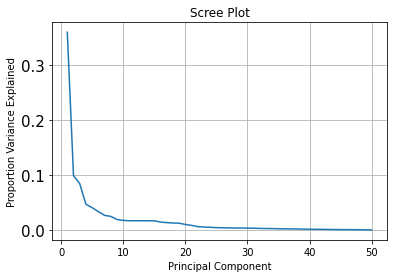

In [86]:
plt.figure()
explained_var = pca_pipe.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.grid(True)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

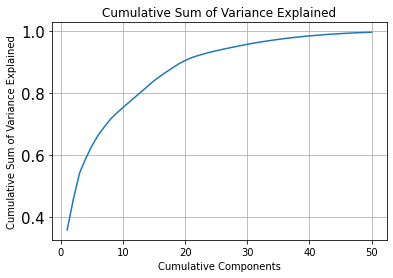

In [87]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.grid(True)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [88]:
# I choose 30 pca

In [89]:
# K-Means
# best pca: 30
# recommender system
kmeans_pca = PCA(k=30, inputCol='std_feature', outputCol='scores')
kmeans_pipe = Pipeline(stages=[recommender_va, standardization, kmeans_pca]).fit(cluster_data_xformed)
kmeans_data = kmeans_pipe.transform(cluster_data_xformed)

In [90]:
km = KMeans(featuresCol='scores', predictionCol='Kmeans_feat')
evaluator = ClusteringEvaluator(featuresCol='scores', predictionCol='Kmeans_feat')

In [91]:
def max_silhouette(k):
  score = []
  for i in range(3):
    km.setK(k)
    km.setSeed(int(np.random.randint(100, size=1)))
    pred = km.fit(kmeans_data).transform(kmeans_data)
    score.append(evaluator.evaluate(pred))
  
  return max(score)


In [92]:
result = []
for i in range(2, 7):
  result.append(max_silhouette(i))

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

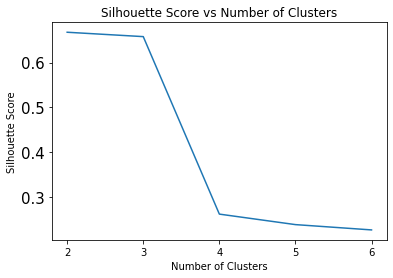

In [93]:
plt.plot(range(2,7), result)
plt.xticks(range(2,7))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

In [94]:
final_km = KMeans(k=2 ,featuresCol='scores', predictionCol='Kmeans_feat')
final_data = final_km.fit(recommender_data).transform(recommender_data)

In [95]:
X = np.array(final_data.select('scores').rdd.map(lambda x: x['scores']).collect())
names = np.array(final_data.select('short_name').rdd.map(lambda x: x['short_name']).collect())

In [96]:
cluster = final_data.select('Kmeans_feat').collect()

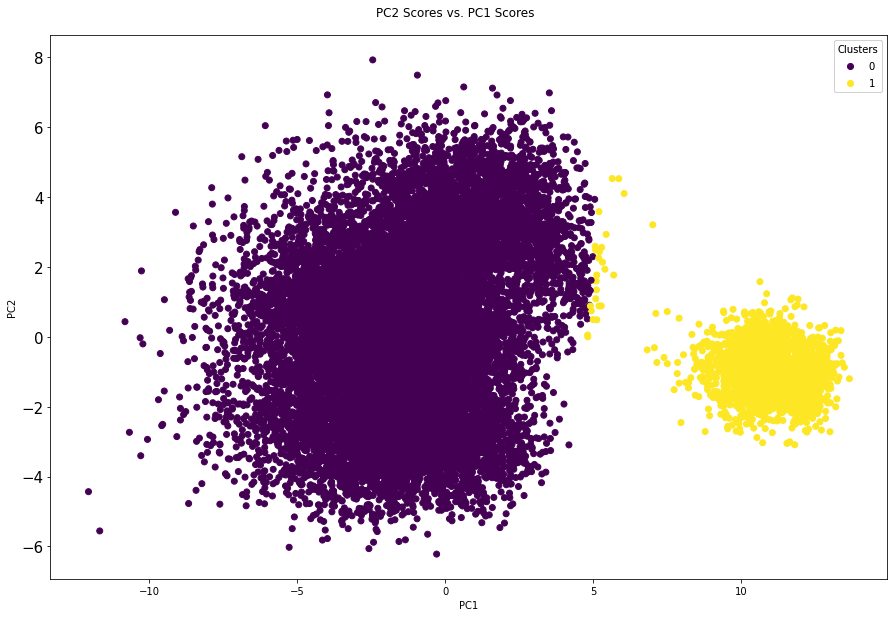

In [97]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
scatter = ax.scatter(X[:,0], X[:,1], c=cluster)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")  
plt.show()